In [9]:
! pip install shap

     |████████████████████████████████| 436 kB 561 kB/s eta 0:00:01
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
     |████████████████████████████████| 78 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 16.9 MB 3.7 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.3
    Uninstalling numpy-1.22.3:
      Successfully uninstalled numpy-1.22.3


In [18]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import shap

## Load the data
We load the adult dataset
This is a clean version, in which the education feature is removed and categorical variables are mapped in numerical ones

In [5]:
dataset = pd.read_csv('adult_clean.csv')

In [6]:
dataset.head()

age  workclass  fnlwgt  education-num  marital-status  occupation  \
0   39          0   77516             13               7          14   
1   50          1   83311             13               1           1   
2   38          2  215646              9               2           2   
3   53          2  234721              7               1           2   
4   28          2  338409             13               1           3   

   relationship  race  sex  capital-gain  capital-loss  hours-per-week  \
0             5     1    0          2174             0              40   
1             1     1    0             0             0              13   
2             5     1    0             0             0              40   
3             1     2    0             0             0              40   
4             2     2    1             0             0              40   

   native-country  class  
0              41      0  
1              41      0  
2              41      0  
3              41      0  
4               1      0

In [7]:
dataset.describe()

age     workclass        fnlwgt  education-num  \
count  30162.000000  30162.000000  3.016200e+04   30162.000000   
mean      38.437902      2.109343  1.897938e+05      10.121312   
std       13.134665      0.934785  1.056530e+05       2.549995   
min       17.000000      0.000000  1.376900e+04       1.000000   
25%       28.000000      2.000000  1.176272e+05       9.000000   
50%       37.000000      2.000000  1.784250e+05      10.000000   
75%       47.000000      2.000000  2.376285e+05      13.000000   
max       90.000000      6.000000  1.484705e+06      16.000000   

       marital-status    occupation  relationship          race           sex  \
count    30162.000000  30162.000000  30162.000000  30162.000000  30162.000000   
mean         3.332272      6.342749      2.775247      1.211823      0.324315   
std          2.708290      4.127163      1.676177      0.612461      0.468126   
min          1.000000      1.000000      1.000000      1.000000      0.000000   
25%          1.000000      3.000000      1.000000      1.000000      0.000000   
50%          2.000000      5.000000      3.000000      1.000000      0.000000   
75%          7.000000     10.000000      5.000000      1.000000      1.000000   
max          7.000000     14.000000      5.000000      5.000000      1.000000   

       capital-gain  capital-loss  hours-per-week  native-country  \
count  30162.000000  30162.000000    30162.000000    30162.000000   
mean    1092.007858     88.372489       40.931238       38.570420   
std     7406.346497    404.298370       11.979984        8.429816   
min        0.000000      0.000000        1.000000        1.000000   
25%        0.000000      0.000000       40.000000       41.000000   
50%        0.000000      0.000000       40.000000       41.000000   
75%        0.000000      0.000000       45.000000       41.000000   
max    99999.000000   4356.000000       99.000000       41.000000   

              class  
count  30162.000000  
mean       0.248922  
std        0.432396  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

### We split the dataset into train and test for training the black-box

In [8]:
test_size = 0.3
random_state = 42
labels = dataset.pop('class')
features = list(dataset.columns)
X_train, X_test, Y_train, Y_test = train_test_split(dataset, labels,
                                                        test_size=test_size,
                                                        random_state=random_state,
                                                        stratify=labels)

### We train the black-box: a Random Forest classifier. To achieve good performance, we conduct a small grid search for the best setting of the hyper-parameters.

In [10]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 150, num = 15)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 15)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [11]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 4)
# Fit the random search model
rf_random.fit(X_test, Y_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 16, 22, 29, 35, 42,
                                                      48, 55, 61, 67, 74, 80,
                                                      87, 93, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150]},
                   random_state=42, verbose=2)

In [12]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 48,
 'bootstrap': True}

### Train the Random Forest and check the performance for both train and test

In [42]:
bb = RandomForestClassifier(n_estimators=140, min_samples_split= 5, min_samples_leaf=4, max_features='sqrt', max_depth=67, bootstrap=True,  random_state=random_state)
bb.fit(X_train, Y_train)

RandomForestClassifier(max_depth=67, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=140, random_state=42)

In [43]:
Y_pred = bb.predict(X_train)
print(classification_report(Y_train, Y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     15857
           1       0.88      0.72      0.79      5256

    accuracy                           0.91     21113
   macro avg       0.90      0.84      0.87     21113
weighted avg       0.90      0.91      0.90     21113



In [44]:
Y_pred = bb.predict(X_test)
print(classification_report(Y_test, Y_pred))


              precision    recall  f1-score   support

           0       0.88      0.94      0.91      6797
           1       0.78      0.62      0.69      2252

    accuracy                           0.86      9049
   macro avg       0.83      0.78      0.80      9049
weighted avg       0.86      0.86      0.86      9049



### Explain the results
Here we focus on post-hoc methods. We can have local or global explanations: in the first case, the goal is to understand the reasons that lead the black-box to classify that record in that way, while in the second case the goal is to understand at a higher level the reasoning of the black-box model.


We first try to explain our black-box model with SHAP. This method allows for different kinds of explainers:

1. Kernel Explainer, it is the real agnostic method for computing Shap values. Hence, it works for every kind of ML model (quite slow).

2. Linear Explainer, for explaining linear models. It is an exact method. It allows for an analysis with independent variables, as well as for correlated ones (you have to estimates the variables covariance matrix).

3. Tree Explainer, for explaining tree-based models (tree and ensambles). Is is an exact algorithm.

4. Gradient Explainer, for explaining deep learning models. It is based on Integrated Gradient and it is an approximation algorithm.

5. Deep Explainer, for explaining deep learning models. It is based on DEEPLift and the method computes an approximation algorithm (faster than Gradient Explainer).
 

In [45]:
shap_values_tree = shap.TreeExplainer(bb).shap_values(X_test[0:200])

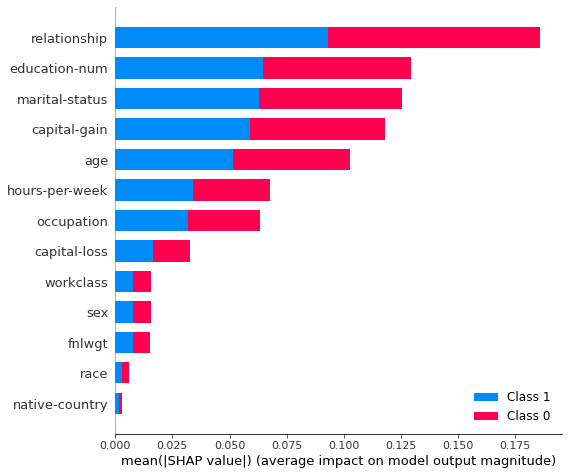

In [46]:
shap.summary_plot(shap_values_tree, X_test[0:200])

In [47]:
shap.initjs()
shap.force_plot(shap.TreeExplainer(bb).expected_value[0], shap_values_tree[0], X_test[0:200])

#### Local Explanation

In [48]:
bb.predict(X_test.values[0].reshape(1, -1))

/Users/narets/opt/anaconda3/envs/collaboration_ISP_SNS/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



array([0])

In [49]:
shap.initjs()
shap.force_plot(shap.TreeExplainer(bb).expected_value[0], shap_values_tree[0][0,:], features)

#### Lime explanation
Local explanation

In [50]:
! pip install lime

In [51]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names = features)

In [61]:
exp = explainer.explain_instance(X_test.values[0], bb.predict_proba, top_labels=1)

/Users/narets/opt/anaconda3/envs/collaboration_ISP_SNS/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



In [53]:
exp.show_in_notebook(show_table=True, show_all=False)

In [54]:
exp = explainer.explain_instance(X_test.values[0], bb.predict_proba, top_labels=0)
exp.show_in_notebook(show_table=True, show_all=False)

/Users/narets/opt/anaconda3/envs/collaboration_ISP_SNS/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



#### Dalex explanation

In [55]:
! pip install dalex

In [56]:
import dalex as dx

In [63]:
exp = dx.Explainer(bb, X_train, Y_train)

Preparation of a new explainer is initiated

  -> data              : 21113 rows 13 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 21113 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7fe513de3670> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.


/Users/narets/opt/anaconda3/envs/collaboration_ISP_SNS/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



  -> predicted values  : min = 0.0, mean = 0.25, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.842, mean = -0.000829, max = 0.906
  -> model_info        : package sklearn

A new explainer has been created!


In [58]:
bb.predict(X_test.iloc[58, :].values.reshape(1, -1))

/Users/narets/opt/anaconda3/envs/collaboration_ISP_SNS/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



array([0])

In [59]:
exp.predict_parts(X_test.iloc[58, :], type='break_down').plot()

In [64]:
ceteris_paribus_ex = exp.predict_profile(X_test.iloc[58, :])
ceteris_paribus_ex.result

Calculating ceteris paribus: 100%|██████████| 13/13 [00:00<00:00, 58.68it/s]


age  workclass   fnlwgt  education-num  marital-status  occupation  \
10664  17.00        2.0  66460.0           10.0             2.0         1.0   
10664  17.73        2.0  66460.0           10.0             2.0         1.0   
10664  18.46        2.0  66460.0           10.0             2.0         1.0   
10664  19.19        2.0  66460.0           10.0             2.0         1.0   
10664  19.92        2.0  66460.0           10.0             2.0         1.0   
...      ...        ...      ...            ...             ...         ...   
10664  42.00        2.0  66460.0           10.0             2.0         1.0   
10664  42.00        2.0  66460.0           10.0             2.0         1.0   
10664  42.00        2.0  66460.0           10.0             2.0         1.0   
10664  42.00        2.0  66460.0           10.0             2.0         1.0   
10664  42.00        2.0  66460.0           10.0             2.0         1.0   

       relationship  race  sex  capital-gain  capital-loss  hours-per-week  \
10664           4.0   1.0  1.0           0.0           0.0            45.0   
10664           4.0   1.0  1.0           0.0           0.0            45.0   
10664           4.0   1.0  1.0           0.0           0.0            45.0   
10664           4.0   1.0  1.0           0.0           0.0            45.0   
10664           4.0   1.0  1.0           0.0           0.0            45.0   
...             ...   ...  ...           ...           ...             ...   
10664           4.0   1.0  1.0           0.0           0.0            45.0   
10664           4.0   1.0  1.0           0.0           0.0            45.0   
10664           4.0   1.0  1.0           0.0           0.0            45.0   
10664           4.0   1.0  1.0           0.0           0.0            45.0   
10664           4.0   1.0  1.0           0.0           0.0            45.0   

       native-country  _original_    _yhat_         _vname_  _ids_  \
10664            41.0          42  0.040852             age  10664   
10664            41.0          42  0.040852             age  10664   
10664            41.0          42  0.040852             age  10664   
10664            41.0          42  0.040852             age  10664   
10664            41.0          42  0.040852             age  10664   
...               ...         ...       ...             ...    ...   
10664            39.4          41  0.077001  native-country  10664   
10664            39.8          41  0.069461  native-country  10664   
10664            40.2          41  0.070056  native-country  10664   
10664            40.6          41  0.070056  native-country  10664   
10664            41.0          41  0.070056  native-country  10664   

                      _label_  
10664  RandomForestClassifier  
10664  RandomForestClassifier  
10664  RandomForestClassifier  
10664  RandomForestClassifier  
10664  RandomForestClassifier  
...                       ...  
10664  RandomForestClassifier  
10664  RandomForestClassifier  
10664  RandomForestClassifier  
10664  RandomForestClassifier  
10664  RandomForestClassifier  

[1318 rows x 18 columns]

In [65]:
ceteris_paribus_ex.plot(variables = ['capital-gain', 'capital-loss'])

### We can visualize more records at the same time

In [67]:
ceteris_58 = exp.predict_profile(X_test.iloc[58, :])
ceteris_paribus_ex.plot(ceteris_58, variables = ['hours-per-week', 'capital-gain'])

Calculating ceteris paribus: 100%|██████████| 13/13 [00:00<00:00, 60.79it/s]
